In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(argparser))) # command line arguments
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # plot patchwork
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggridges))) # ridgeline plots
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # color palettes
suppressPackageStartupMessages(suppressWarnings(library(cowplot))) # ggplot2 drawing
suppressPackageStartupMessages(suppressWarnings(library(ggplotify))) # ggplot2 drawing
suppressPackageStartupMessages(suppressWarnings(library(RcppTOML))) # parsing config file
suppressPackageStartupMessages(suppressWarnings(library(tidyverse))) # data manipulation


source("../../utils/figure_themes.r")


In [2]:
cell_type <- "PBMC"

## Bulk profiles all treatments UMAP

In [3]:
bulk_profile_umap_path <- file.path("..","..","..",paste0("1.Exploratory_Data_Analysis/results/",cell_type,"_umap_bulk_profile.parquet"))
bulk_profile_umap_df <- arrow::read_parquet(bulk_profile_umap_path)

# Load data
# read in the ground truth data
data_path_ground_truth <- file.path("../../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml")
ground_truth <- parseTOML(data_path_ground_truth)
# make a a list of the treatments that are in the ground truth data
apoptosis_ground_truth_list <- c(ground_truth$Apoptosis$apoptosis_groups_list)
pyroptosis_ground_truth_list <- c(ground_truth$Pyroptosis$pyroptosis_groups_list)
control_ground_truth_list <- c(ground_truth$Healthy$healthy_groups_list)


# replace Flagellin_0.100_ug_per_ml_DMSO_0.0_% with Flagellin_0.100_ug_per_ml_DMSO_0.025_%

bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_0.100_ug_per_ml_DMSO_0.000_%", "Flagellin_0.100_ug_per_ml_DMSO_0.025_%", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "media_ctr_0.0_0_Media_0_0", "media_ctr_0.0_0_Media_ctr_0.0_0", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_Disulfiram_1.000_uM", "Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_DMSO_0.025_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)

# make a new column that is the treatment group based on the ground truth data
bulk_profile_umap_df$group <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
bulk_profile_umap_df$group <- factor(bulk_profile_umap_df$group, levels = c("Control","Apoptosis", "Pyroptosis"))
head(bulk_profile_umap_df)

Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,UMAP1,UMAP2,group
<chr>,<chr>,<dbl>,<dbl>,<fct>
B02,LPS_0.010_ug_per_ml_DMSO_0.025_%,5.188682,5.4528756,Pyroptosis
B03,LPS_0.010_ug_per_ml_DMSO_0.025_%,5.016584,4.1818881,Pyroptosis
B04,LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%,6.086578,7.2938809,Pyroptosis
B05,LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%,5.655705,8.1133642,Pyroptosis
B06,DMSO_0.100_%_DMSO_0.025_%,3.502944,-0.5087467,Control
B07,DMSO_0.100_%_DMSO_0.025_%,3.295627,-1.1089518,Control


In [4]:

# mutate the names of each treatment
bulk_profile_umap_df <- bulk_profile_umap_df %>%
    mutate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% - DMSO 1.0%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 30.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml - Disulfiram 0.1 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml - Disulfiram 2.5 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Media' ~ "Media - Media",
    ))


In [5]:

# split the oneb_Metadata_Treatment_Dose_Inhibitor_Dose into two columns by the " - " delimiter
bulk_profile_umap_df <- bulk_profile_umap_df %>%
    separate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose, c("inducer", "inhibitor"), sep = " - ", remove = FALSE)
unique(bulk_profile_umap_df$inducer)
# replace the inhibitor NA with Media
bulk_profile_umap_df$inhibitor <- ifelse(is.na(bulk_profile_umap_df$inhibitor), "Media", bulk_profile_umap_df$inhibitor)
unique(bulk_profile_umap_df$inhibitor)


[1] "LPS 0.01 ug/ml"                      "LPS 100.0 ug/ml + Nigericin 1.0 uM" 
 [3] "DMSO 0.1%"                           "Media"                              
 [5] "LPS 0.1 ug/ml"                       "LPS 100.0 ug/ml + Nigericin 3.0 uM" 
 [7] "LPS 1.0 ug/ml"                       "LPS 100.0 ug/ml + Nigericin 10.0 uM"
 [9] "Thapsigargin 1.0 uM"                 "LPS 10.0 ug/ml"                     
[11] "Disulfiram 0.1 uM"                   "Thapsigargin 10.0 uM"               
[13] "Disulfiram 1.0 uM"                   "Topotecan 5.0 nM"                   
[15] "Disulfiram 2.5 uM"                   "Topotecan 10.0 nM"                  
[17] "H2O2 100.0 nM"                       "Topotecan 20.0 nM"                  
[19] "H2O2 100.0 uM"                       "LPS 100.0 ug/ml"                    
[21] "LPS 1.0 ug/ml + Nigericin 1.0 uM"    "LPS 1.0 ug/ml + Nigericin 3.0 uM"   
[23] "Flagellin 0.1 ug/ml"                 "LPS 1.0 ug/ml + Nigericin 10.0 uM"  
[25] "Flagellin 1.0 ug/ml"

[1] "DMSO 0.025%"        "Media"              "DMSO 1.0%"         
[4] "Z-VAD-FMK 100.0 uM" "Z-VAD-FMK 30.0 uM"  "Disulfiram 0.1 uM" 
[7] "Disulfiram 1.0 uM"  "Disulfiram 2.5 uM"

In [6]:

# make the group_treatment column a factor
bulk_profile_umap_df$inducer <- factor(
    bulk_profile_umap_df$inducer, 
    levels = c(
        'Media',
        'DMSO 0.1%',

        'Flagellin 0.1 ug/ml',
        'Flagellin 1.0 ug/ml',

        'LPS 0.01 ug/ml',
        'LPS 0.1 ug/ml',
        'LPS 1.0 ug/ml',
        'LPS 10.0 ug/ml',
        'LPS 100.0 ug/ml',

        'LPS 1.0 ug/ml + Nigericin 1.0 uM',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM',
        
        'LPS 100.0 ug/ml + Nigericin 1.0 uM',
        'LPS 100.0 ug/ml + Nigericin 3.0 uM',
        'LPS 100.0 ug/ml + Nigericin 10.0 uM',
        
        'H2O2 100.0 nM',
        'H2O2 100.0 uM',
        
        'Disulfiram 0.1 uM',
        'Disulfiram 1.0 uM',
        'Disulfiram 2.5 uM',

        'Thapsigargin 1.0 uM',
        'Thapsigargin 10.0 uM',

        'Topotecan 5.0 nM',
        'Topotecan 10.0 nM',
        'Topotecan 20.0 nM'
    )
)

# make the group_treatment column a factor
bulk_profile_umap_df$inhibitor <- factor(
    bulk_profile_umap_df$inhibitor, 
    levels = c(
        'Media',
        'DMSO 0.025%',
        'DMSO 1.0%',
        
        'Disulfiram 0.1 uM',
        'Disulfiram 1.0 uM',
        'Disulfiram 2.5 uM',
        
        'Z-VAD-FMK 30.0 uM',
        'Z-VAD-FMK 100.0 uM'
    )
)

            
head(bulk_profile_umap_df)


Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,inducer,inhibitor,UMAP1,UMAP2,group
<chr>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<fct>
B02,LPS 0.01 ug/ml - DMSO 0.025%,LPS 0.01 ug/ml,DMSO 0.025%,5.188682,5.4528756,Pyroptosis
B03,LPS 0.01 ug/ml - DMSO 0.025%,LPS 0.01 ug/ml,DMSO 0.025%,5.016584,4.1818881,Pyroptosis
B04,LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%,LPS 100.0 ug/ml + Nigericin 1.0 uM,DMSO 0.025%,6.086578,7.2938809,Pyroptosis
B05,LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%,LPS 100.0 ug/ml + Nigericin 1.0 uM,DMSO 0.025%,5.655705,8.1133642,Pyroptosis
B06,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,3.502944,-0.5087467,Control
B07,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,3.295627,-1.1089518,Control


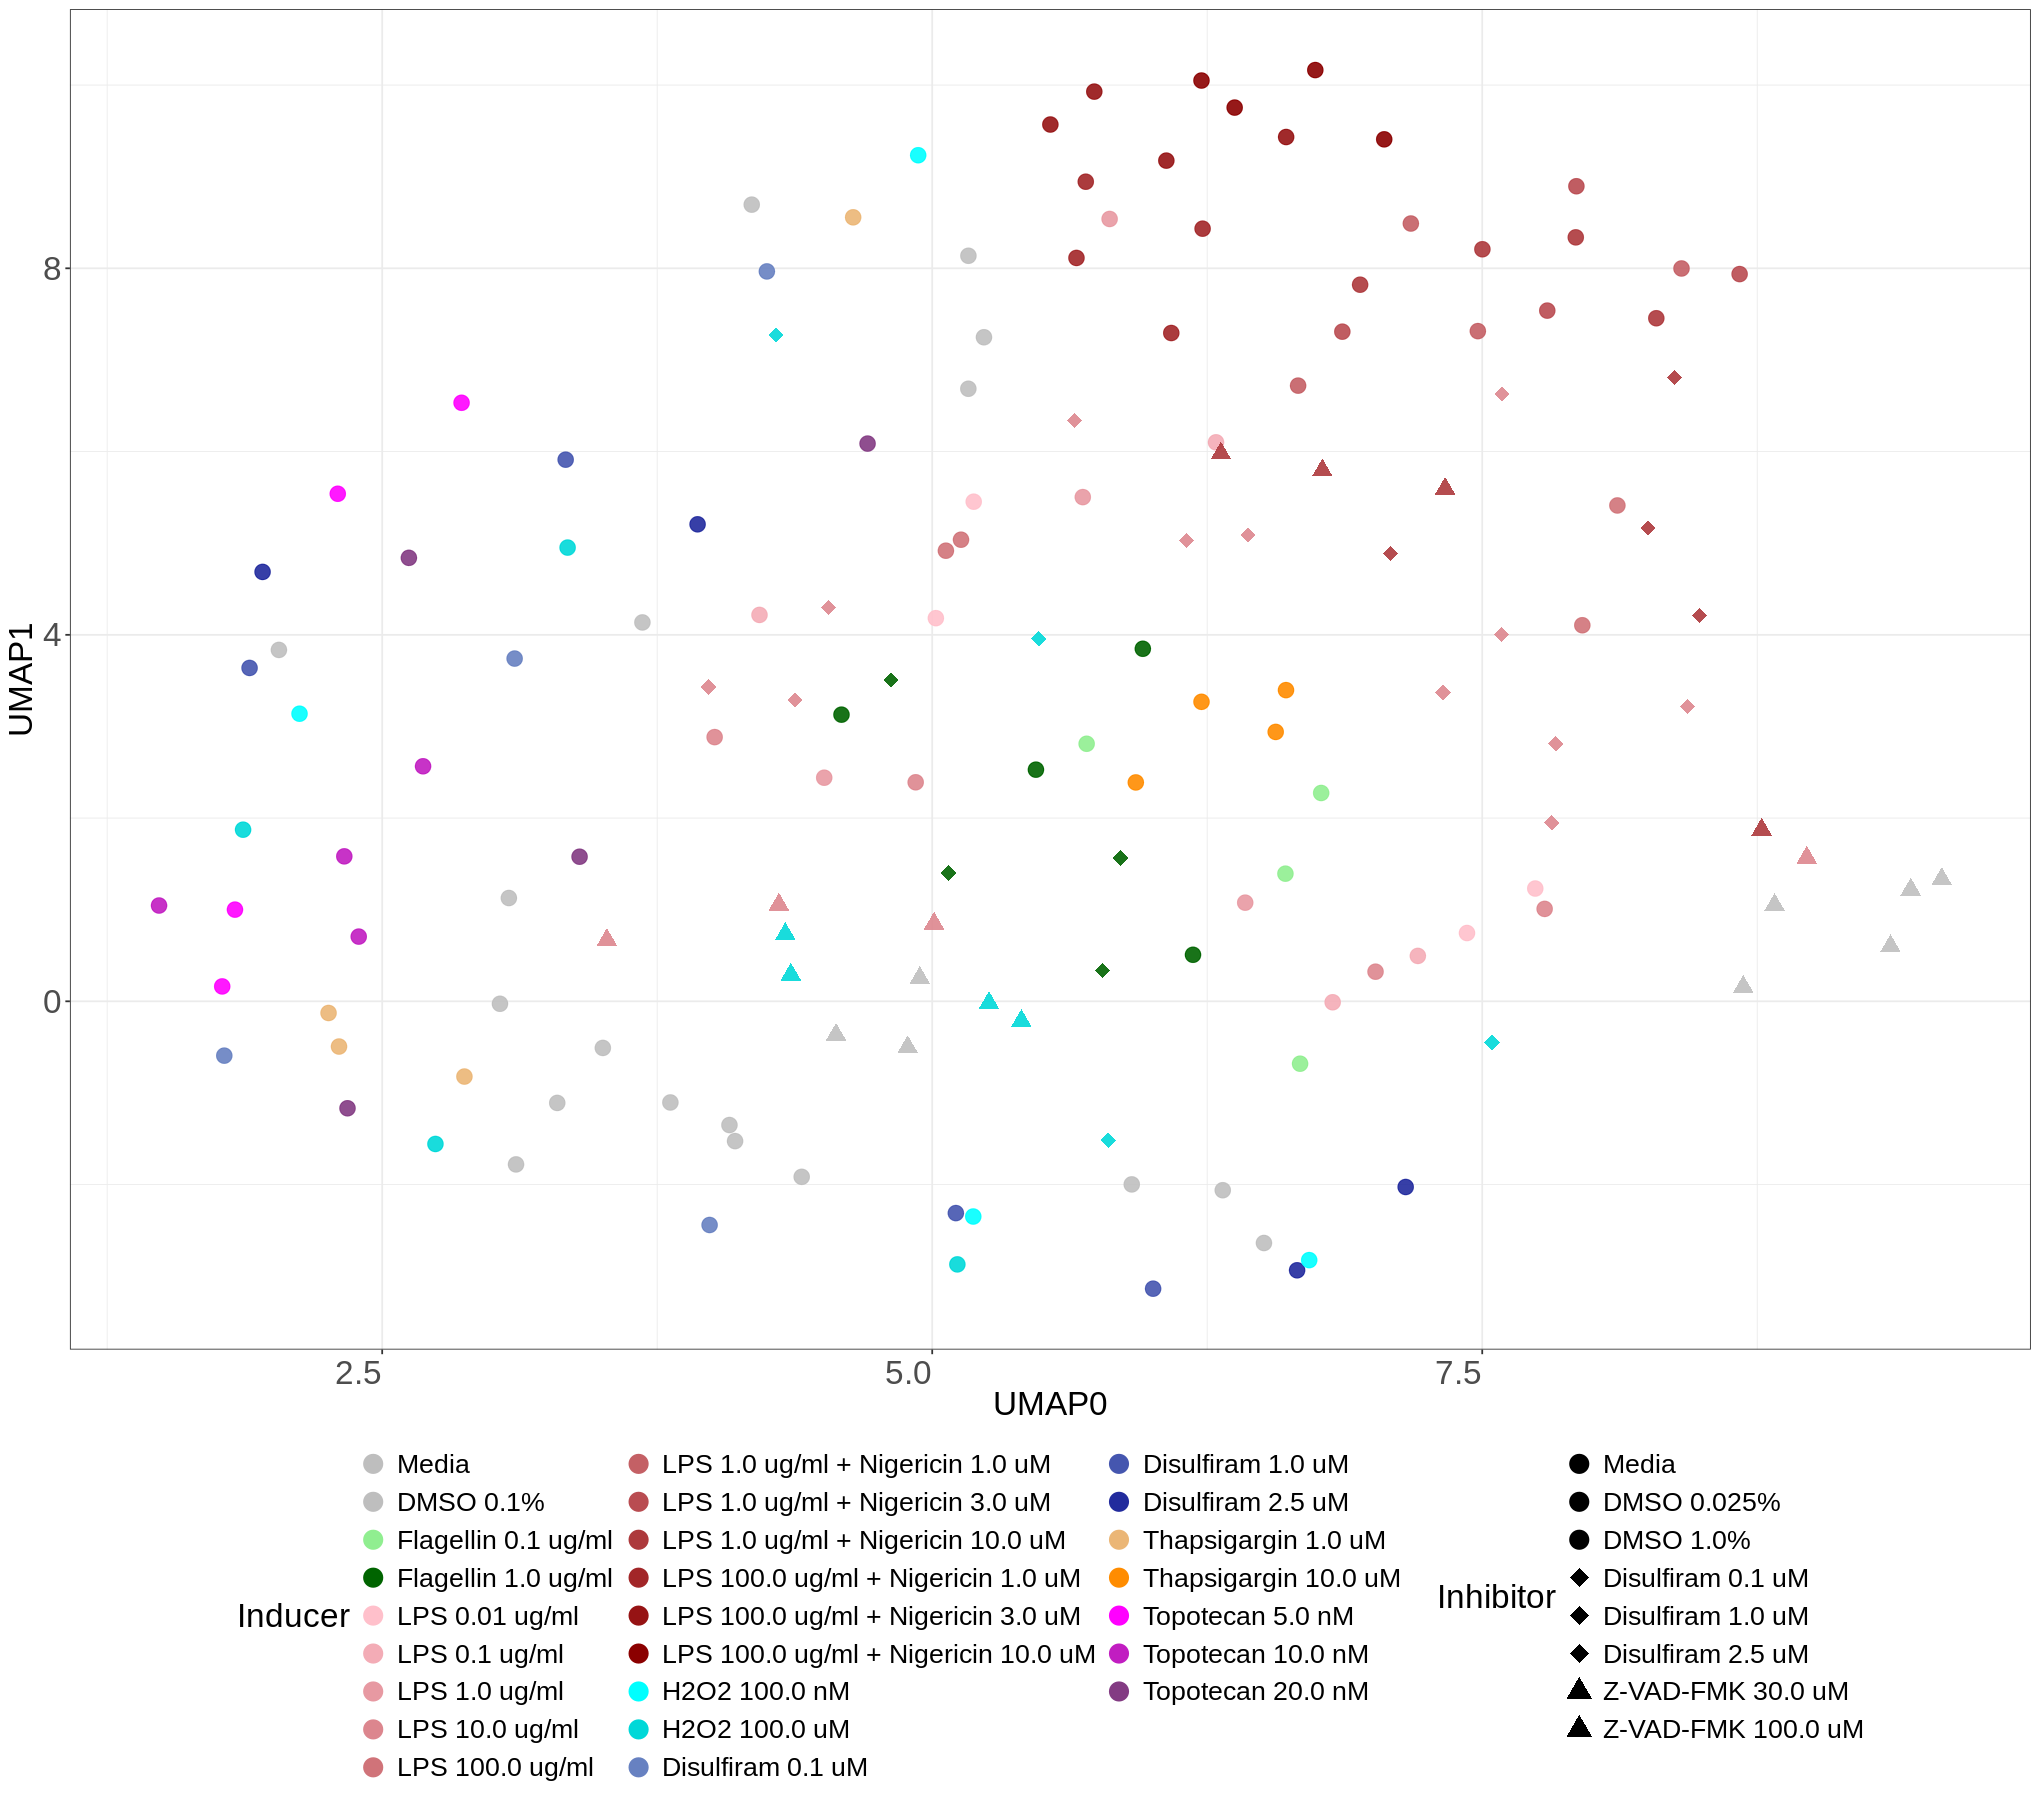

In [7]:
# set plot size 
width <- 17
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
umap_plot_all <- (
    ggplot(bulk_profile_umap_df, aes(x = UMAP1, y = UMAP2)) 

    + geom_point(
        aes(
            color = inducer,
            shape = inhibitor
        ), 
        size = 4, 
        alpha = 0.9
    )
    + theme_bw()
    + figure_theme

    # rename legend title
    + figure_theme
        + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))
            + theme(
        legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
    + scale_color_manual(
        name = "Inducer",
        labels = c(
            'Media',
            'DMSO 0.1%',

            'Flagellin 0.1 ug/ml',
            'Flagellin 1.0 ug/ml',

            'LPS 0.01 ug/ml',
            'LPS 0.1 ug/ml',
            'LPS 1.0 ug/ml',
            'LPS 10.0 ug/ml',
            'LPS 100.0 ug/ml',

            'LPS 1.0 ug/ml + Nigericin 1.0 uM',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM',
            
            'LPS 100.0 ug/ml + Nigericin 1.0 uM',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM',
            
            'H2O2 100.0 nM',
            'H2O2 100.0 uM',
            
            'Disulfiram 0.1 uM',
            'Disulfiram 1.0 uM',
            'Disulfiram 2.5 uM',

            'Thapsigargin 1.0 uM',
            'Thapsigargin 10.0 uM',

            'Topotecan 5.0 nM',
            'Topotecan 10.0 nM',
            'Topotecan 20.0 nM'
        ),
        values = colors)
    + scale_shape_manual(
        name = "Inhibitor",
        labels = c(
            'Media',
            'DMSO 0.025%',
            'DMSO 1.0%',
            
            'Disulfiram 0.1 uM',
            'Disulfiram 1.0 uM',
            'Disulfiram 2.5 uM',
            
            'Z-VAD-FMK 30.0 uM',
            'Z-VAD-FMK 100.0 uM'
            
        ),
        values = shapes
    )
    + theme(legend.position = "bottom")
    # set the legend columns to 4
    # change legend alpha 
    + guides(color = guide_legend(ncol = 3, override.aes = list(alpha = 1, size = 5)))
    + guides(shape = guide_legend(ncol = 1, override.aes = list(alpha = 1, size = 5)))
    + labs(
        x = "UMAP0",
        y = "UMAP1"
    )   
)
umap_plot_all
# save plot
ggsave(
    filename = file.path("..","figures", "all_treatments_bulk_umap.png"),
    plot = umap_plot_all,
    width = width,
    height = height,
    units = "in",
    dpi = 600
)


## Bulk profiles selected treatments UMAP

In [8]:
bulk_profile_umap_path <- file.path("..","..","..","1.Exploratory_Data_Analysis/results/umap_bulk_profile.parquet")
bulk_profile_umap_df <- arrow::read_parquet(bulk_profile_umap_path)
head(bulk_profile_umap_df)


Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,UMAP1,UMAP2
<chr>,<chr>,<dbl>,<dbl>
B02,LPS_0.010_ug_per_ml_DMSO_0.025_%,5.188682,5.4528756
B03,LPS_0.010_ug_per_ml_DMSO_0.025_%,5.016584,4.1818881
B04,LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%,6.086578,7.2938809
B05,LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%,5.655705,8.1133642
B06,DMSO_0.100_%_DMSO_0.025_%,3.502944,-0.5087467
B07,DMSO_0.100_%_DMSO_0.025_%,3.295627,-1.1089518


In [9]:

# Load data
# read in the ground truth data
data_path_ground_truth <- file.path("../../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml")
ground_truth <- parseTOML(data_path_ground_truth)
# make a a list of the treatments that are in the ground truth data
apoptosis_ground_truth_list <- c(ground_truth$Apoptosis$apoptosis_groups_list)
pyroptosis_ground_truth_list <- c(ground_truth$Pyroptosis$pyroptosis_groups_list)
control_ground_truth_list <- c(ground_truth$Healthy$healthy_groups_list)
toml_path <- file.path("..","..","../","1.Exploratory_Data_Analysis/utils/params.toml")
p <- parseTOML(toml_path)
# get the list that is in the toml file under the key "treatments"
# define that list as a variable called list_of_treatments and print the list to verify
list_of_treatments <- c(p$list_of_treatments$treatments)
bulk_profile_umap_df <- bulk_profile_umap_df %>% filter(oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% list_of_treatments)
# replace Flagellin_0.100_ug_per_ml_DMSO_0.0_% with Flagellin_0.100_ug_per_ml_DMSO_0.025_%

bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_0.100_ug_per_ml_DMSO_0.000_%", "Flagellin_0.100_ug_per_ml_DMSO_0.025_%", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "media_ctr_0.0_0_Media_0_0", "media_ctr_0.0_0_Media_ctr_0.0_0", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_Disulfiram_1.000_uM", "Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_DMSO_0.025_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)

# make a new column that is the treatment group based on the ground truth data
bulk_profile_umap_df$group <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
bulk_profile_umap_df$group <- factor(bulk_profile_umap_df$group, levels = c("Control","Apoptosis", "Pyroptosis"))

head(bulk_profile_umap_df)
unique(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)

Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,UMAP1,UMAP2,group
<chr>,<chr>,<dbl>,<dbl>,<fct>
B02,LPS_0.010_ug_per_ml_DMSO_0.025_%,5.188682,5.4528756,Pyroptosis
B03,LPS_0.010_ug_per_ml_DMSO_0.025_%,5.016584,4.1818881,Pyroptosis
B06,DMSO_0.100_%_DMSO_0.025_%,3.502944,-0.5087467,Control
B07,DMSO_0.100_%_DMSO_0.025_%,3.295627,-1.1089518,Control
B08,LPS_0.010_ug_per_ml_DMSO_0.025_%,7.430720,0.7453578,Pyroptosis
B09,LPS_0.010_ug_per_ml_DMSO_0.025_%,7.740998,1.2309819,Pyroptosis


[1] "LPS_0.010_ug_per_ml_DMSO_0.025_%"                    
 [2] "DMSO_0.100_%_DMSO_0.025_%"                           
 [3] "LPS_0.100_ug_per_ml_DMSO_0.025_%"                    
 [4] "LPS_1.000_ug_per_ml_DMSO_0.025_%"                    
 [5] "Thapsigargin_1.000_uM_DMSO_0.025_%"                  
 [6] "LPS_10.000_ug_per_ml_DMSO_0.025_%"                   
 [7] "Thapsigargin_10.000_uM_DMSO_0.025_%"                 
 [8] "H2O2_100.000_nM_DMSO_0.025_%"                        
 [9] "H2O2_100.000_uM_DMSO_0.025_%"                        
[10] "LPS_100.000_ug_per_ml_DMSO_0.025_%"                  
[11] "LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%" 
[12] "LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%" 
[13] "Flagellin_0.100_ug_per_ml_DMSO_0.025_%"              
[14] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%"
[15] "Flagellin_1.000_ug_per_ml_DMSO_0.025_%"

In [10]:

# mutate the names of each treatment
bulk_profile_umap_df <- bulk_profile_umap_df %>%
    mutate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% - DMSO 1.0%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 30.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.0%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml - Disulfiram 0.1 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml - Disulfiram 2.5 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Media' ~ "Media - Media",
    ))
head(bulk_profile_umap_df)
unique(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)

Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,UMAP1,UMAP2,group
<chr>,<chr>,<dbl>,<dbl>,<fct>
B02,LPS 0.01 ug/ml - DMSO 0.025%,5.188682,5.4528756,Pyroptosis
B03,LPS 0.01 ug/ml - DMSO 0.025%,5.016584,4.1818881,Pyroptosis
B06,DMSO 0.1% - DMSO 0.025%,3.502944,-0.5087467,Control
B07,DMSO 0.1% - DMSO 0.025%,3.295627,-1.1089518,Control
B08,LPS 0.01 ug/ml - DMSO 0.025%,7.430720,0.7453578,Pyroptosis
B09,LPS 0.01 ug/ml - DMSO 0.025%,7.740998,1.2309819,Pyroptosis


[1] "LPS 0.01 ug/ml - DMSO 0.025%"                   
 [2] "DMSO 0.1% - DMSO 0.025%"                        
 [3] "LPS 0.1 ug/ml - DMSO 0.025%"                    
 [4] "LPS 1.0 ug/ml - DMSO 0.025%"                    
 [5] "Thapsigargin 1.0 uM - DMSO 0.025%"              
 [6] "LPS 10.0 ug/ml - DMSO 0.025%"                   
 [7] "Thapsigargin 10.0 uM - DMSO 0.025%"             
 [8] "H2O2 100.0 nM - DMSO 0.025%"                    
 [9] "H2O2 100.0 uM - DMSO 0.025%"                    
[10] "LPS 100.0 ug/ml - DMSO 0.025%"                  
[11] "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%" 
[12] "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%" 
[13] "Flagellin 0.1 ug/ml - DMSO 0.025%"              
[14] "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%"
[15] "Flagellin 1.0 ug/ml - DMSO 0.025%"

In [11]:

# split the oneb_Metadata_Treatment_Dose_Inhibitor_Dose into two columns by the " - " delimiter
bulk_profile_umap_df <- bulk_profile_umap_df %>%
    separate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose, c("inducer", "inhibitor"), sep = " - ", remove = FALSE)
unique(bulk_profile_umap_df$inducer)
# replace the inhibitor NA with Media
bulk_profile_umap_df$inhibitor <- ifelse(is.na(bulk_profile_umap_df$inhibitor), "Media", bulk_profile_umap_df$inhibitor)
unique(bulk_profile_umap_df$inhibitor)


[1] "LPS 0.01 ug/ml"                    "DMSO 0.1%"                        
 [3] "LPS 0.1 ug/ml"                     "LPS 1.0 ug/ml"                    
 [5] "Thapsigargin 1.0 uM"               "LPS 10.0 ug/ml"                   
 [7] "Thapsigargin 10.0 uM"              "H2O2 100.0 nM"                    
 [9] "H2O2 100.0 uM"                     "LPS 100.0 ug/ml"                  
[11] "LPS 1.0 ug/ml + Nigericin 1.0 uM"  "LPS 1.0 ug/ml + Nigericin 3.0 uM" 
[13] "Flagellin 0.1 ug/ml"               "LPS 1.0 ug/ml + Nigericin 10.0 uM"
[15] "Flagellin 1.0 ug/ml"

[1] "DMSO 0.025%"

In [12]:

# make the group_treatment column a factor
bulk_profile_umap_df$inducer <- factor(
    bulk_profile_umap_df$inducer, 
    levels = c(
        'DMSO 0.1%',
        'Flagellin 0.1 ug/ml',
        'Flagellin 1.0 ug/ml',

        'LPS 0.01 ug/ml',
        'LPS 0.1 ug/ml',
        'LPS 1.0 ug/ml',
        'LPS 10.0 ug/ml',
        'LPS 100.0 ug/ml',
        
        'LPS 1.0 ug/ml + Nigericin 1.0 uM',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM',

        'H2O2 100.0 nM',
        'H2O2 100.0 uM',
        
        'Thapsigargin 1.0 uM',
        'Thapsigargin 10.0 uM'
    )
)

# make the group_treatment column a factor
bulk_profile_umap_df$inhibitor <- factor(
    bulk_profile_umap_df$inhibitor, 
    levels = c(
        'Media',
        'DMSO 0.025%',
        'DMSO 1.0%',
        
        'Disulfiram 0.1 uM',
        'Disulfiram 1.0 uM',
        'Disulfiram 2.5 uM',
        
        'Z-VAD-FMK 30.0 uM',
        'Z-VAD-FMK 100.0 uM'
    )
)

            
head(bulk_profile_umap_df)

Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,inducer,inhibitor,UMAP1,UMAP2,group
<chr>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<fct>
B02,LPS 0.01 ug/ml - DMSO 0.025%,LPS 0.01 ug/ml,DMSO 0.025%,5.188682,5.4528756,Pyroptosis
B03,LPS 0.01 ug/ml - DMSO 0.025%,LPS 0.01 ug/ml,DMSO 0.025%,5.016584,4.1818881,Pyroptosis
B06,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,3.502944,-0.5087467,Control
B07,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,3.295627,-1.1089518,Control
B08,LPS 0.01 ug/ml - DMSO 0.025%,LPS 0.01 ug/ml,DMSO 0.025%,7.430720,0.7453578,Pyroptosis
B09,LPS 0.01 ug/ml - DMSO 0.025%,LPS 0.01 ug/ml,DMSO 0.025%,7.740998,1.2309819,Pyroptosis


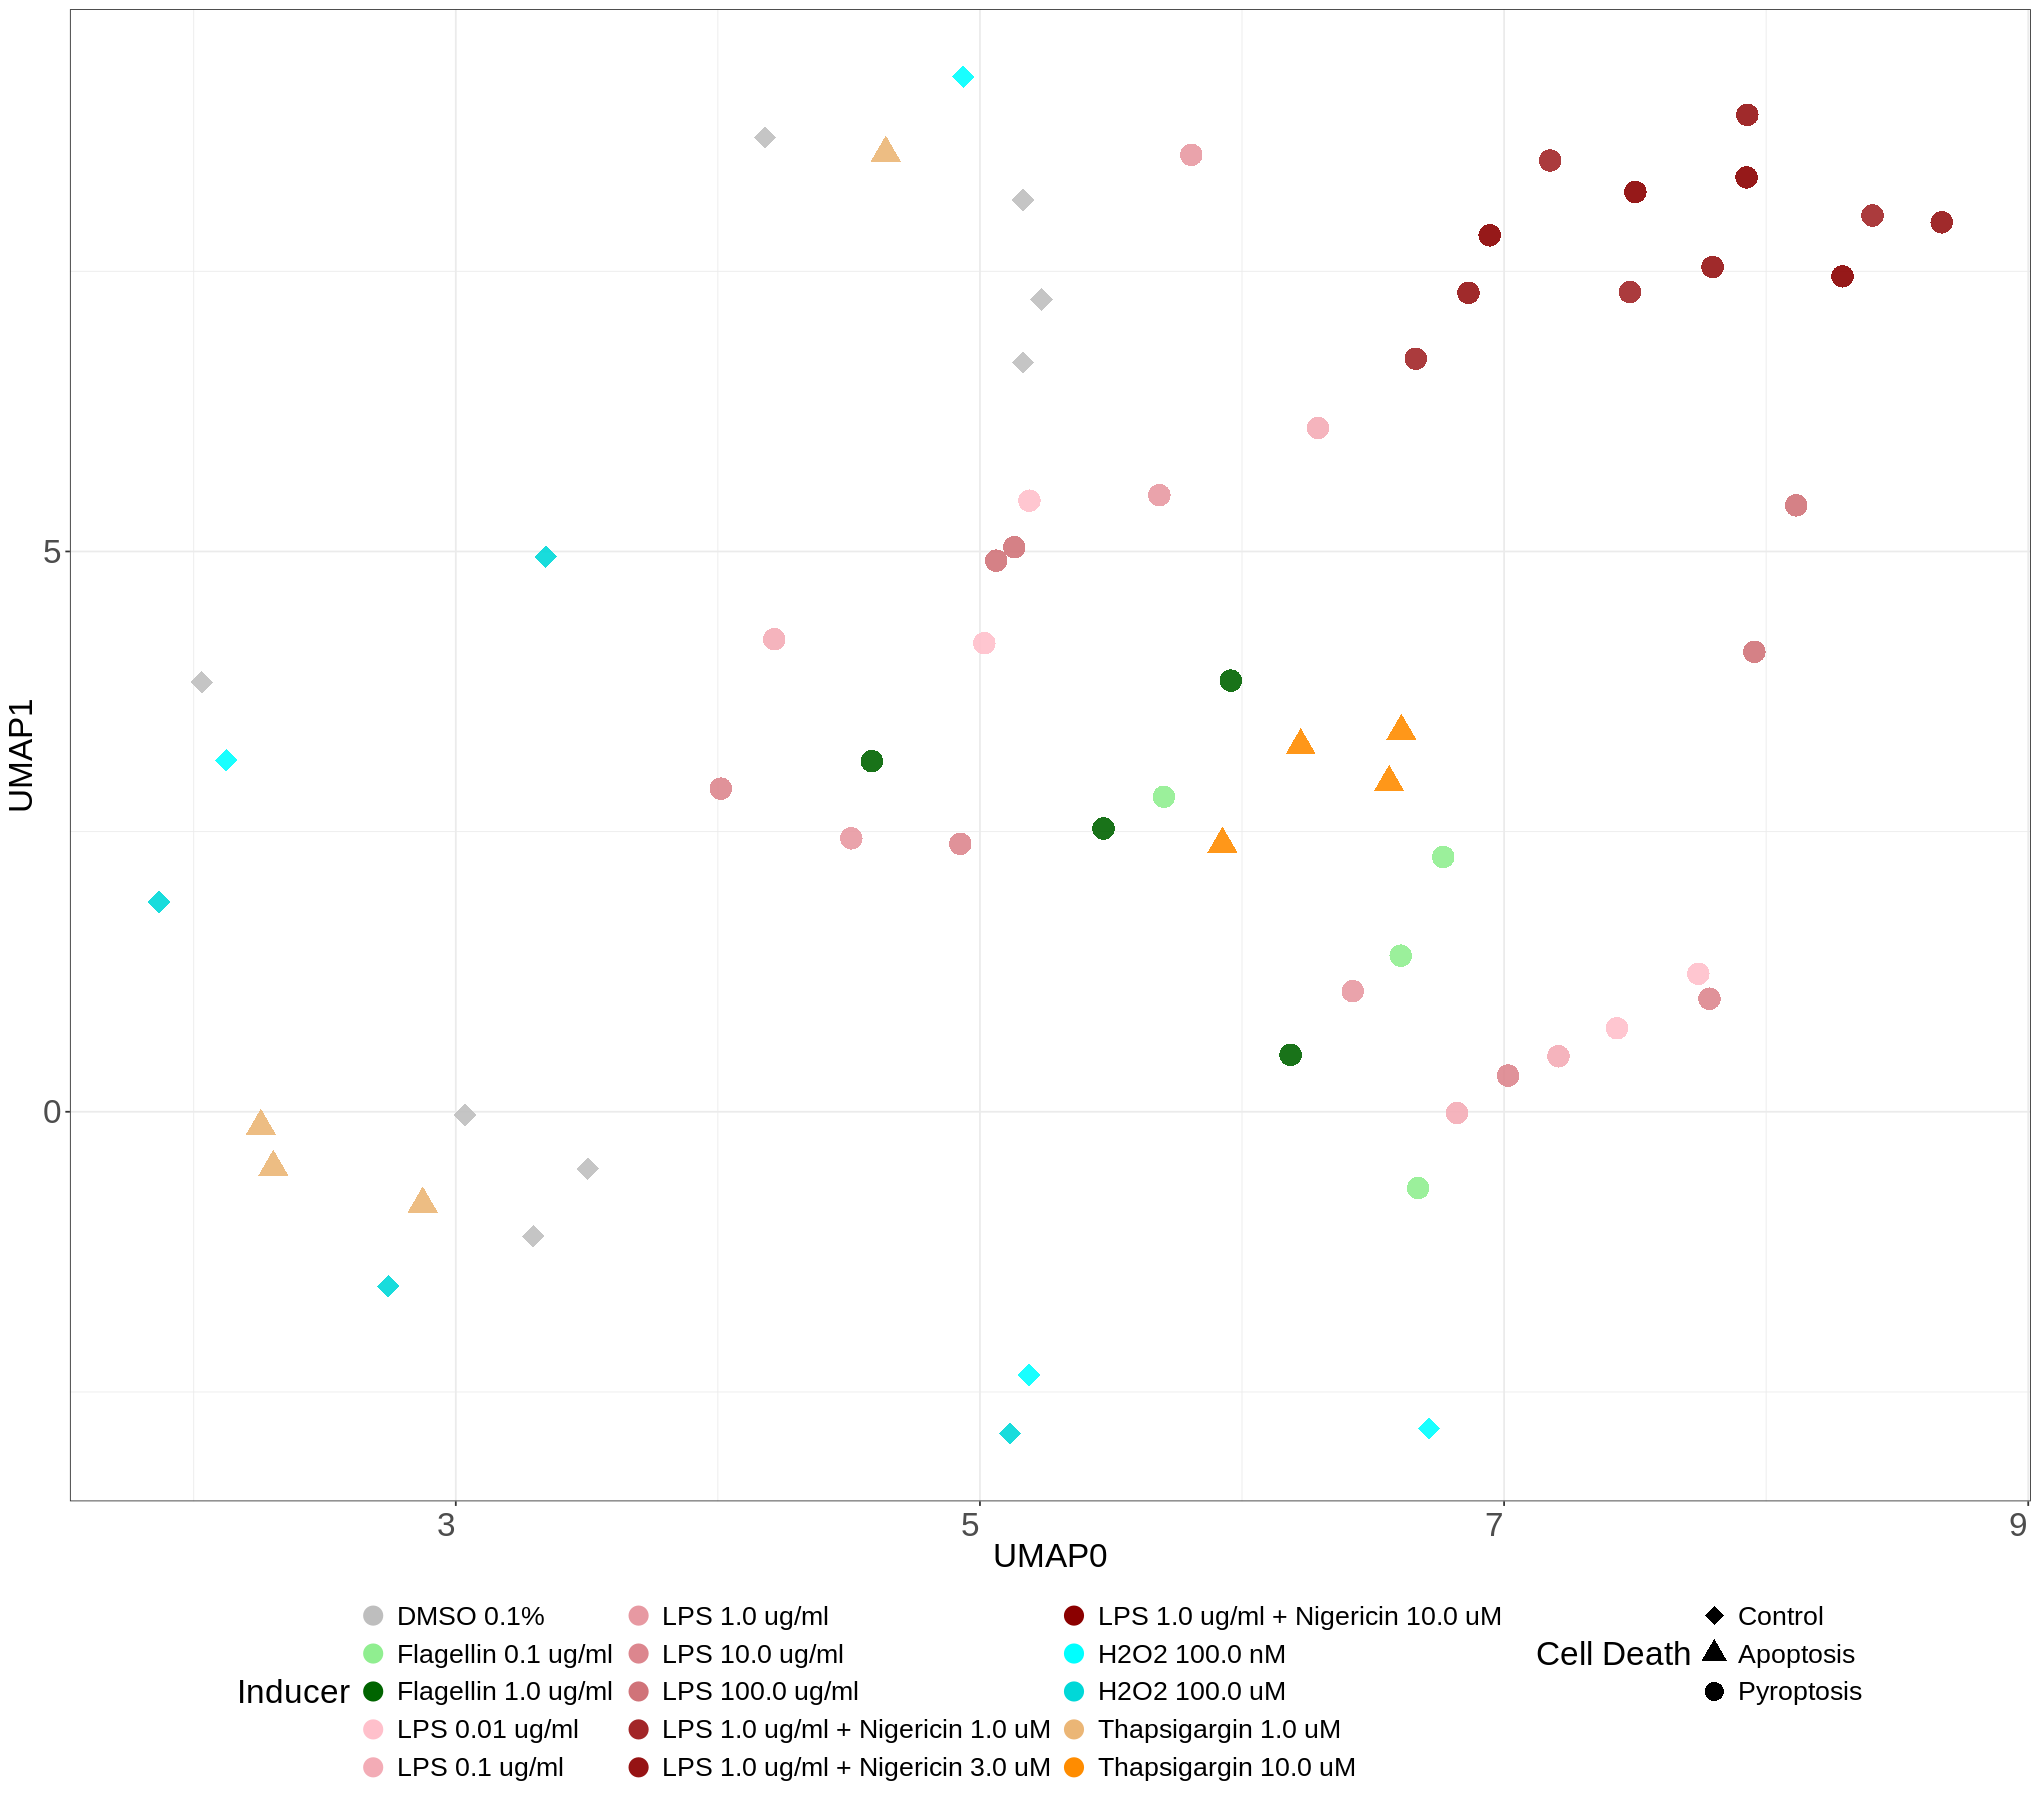

In [13]:
# set plot size 
width <- 17
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
umap_plot_all <- (
    ggplot(bulk_profile_umap_df, aes(x = UMAP1, y = UMAP2)) 

    + geom_point(
        aes(
            color = inducer,
            shape = group
        ), 
        size = 6, 
        alpha = 0.9
    )
    + theme_bw()
    + figure_theme

    # rename legend title
    + figure_theme
        + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))
            + theme(
        legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
    + scale_color_manual(
        name = "Inducer",
        labels = c(
            'DMSO 0.1%',

            'Flagellin 0.1 ug/ml',
            'Flagellin 1.0 ug/ml',

            'LPS 0.01 ug/ml',
            'LPS 0.1 ug/ml',
            'LPS 1.0 ug/ml',
            'LPS 10.0 ug/ml',
            'LPS 100.0 ug/ml',

            'LPS 1.0 ug/ml + Nigericin 1.0 uM',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM',
            

            
            'H2O2 100.0 nM',
            'H2O2 100.0 uM',
            

            'Thapsigargin 1.0 uM',
            'Thapsigargin 10.0 uM'

        ),
        values = colors_3)
    + scale_shape_manual(
        name = "Cell Death",
        labels = c(
            "Control",
            "Apoptosis",
            "Pyroptosis"
            
        ),
        values = c(18,17,16)
    )
    + theme(legend.position = "bottom")
    # set the legend columns to 4
    # change legend alpha 
    + guides(color = guide_legend(ncol = 3, override.aes = list(alpha = 1, size = 5)))
    + guides(shape = guide_legend(ncol = 1, override.aes = list(alpha = 1, size = 5)))
    + labs(
        x = "UMAP0",
        y = "UMAP1"
    )   
)
umap_plot_all
# save plot
ggsave(
    filename = file.path("..","figures", "selected_treatments_bulk_umap.png"),
    plot = umap_plot_all,
    width = width,
    height = height,
    units = "in",
    dpi = 600
)


## Bulk profiles Cell death class all treatments UMAP

In [14]:
bulk_profile_umap_path <- file.path("..","..","..","1.Exploratory_Data_Analysis/results/umap_bulk_profile.parquet")
bulk_profile_umap_df <- arrow::read_parquet(bulk_profile_umap_path)
head(bulk_profile_umap_df)


Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,UMAP1,UMAP2
<chr>,<chr>,<dbl>,<dbl>
B02,LPS_0.010_ug_per_ml_DMSO_0.025_%,5.188682,5.4528756
B03,LPS_0.010_ug_per_ml_DMSO_0.025_%,5.016584,4.1818881
B04,LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%,6.086578,7.2938809
B05,LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%,5.655705,8.1133642
B06,DMSO_0.100_%_DMSO_0.025_%,3.502944,-0.5087467
B07,DMSO_0.100_%_DMSO_0.025_%,3.295627,-1.1089518


In [15]:

# Load data
# read in the ground truth data
data_path_ground_truth <- file.path("../../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml")
ground_truth <- parseTOML(data_path_ground_truth)
# make a a list of the treatments that are in the ground truth data
apoptosis_ground_truth_list <- c(ground_truth$Apoptosis$apoptosis_groups_list)
pyroptosis_ground_truth_list <- c(ground_truth$Pyroptosis$pyroptosis_groups_list)
control_ground_truth_list <- c(ground_truth$Healthy$healthy_groups_list)
# replace Flagellin_0.100_ug_per_ml_DMSO_0.0_% with Flagellin_0.100_ug_per_ml_DMSO_0.025_%

bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_0.100_ug_per_ml_DMSO_0.000_%", "Flagellin_0.100_ug_per_ml_DMSO_0.025_%", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "media_ctr_0.0_0_Media_0_0", "media_ctr_0.0_0_Media_ctr_0.0_0", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_Disulfiram_1.000_uM", "Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_DMSO_0.025_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)

# make a new column that is the treatment group based on the ground truth data
bulk_profile_umap_df$group <- ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(bulk_profile_umap_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
bulk_profile_umap_df$group <- factor(bulk_profile_umap_df$group, levels = c("Control","Apoptosis", "Pyroptosis"))

head(bulk_profile_umap_df)

Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,UMAP1,UMAP2,group
<chr>,<chr>,<dbl>,<dbl>,<fct>
B02,LPS_0.010_ug_per_ml_DMSO_0.025_%,5.188682,5.4528756,Pyroptosis
B03,LPS_0.010_ug_per_ml_DMSO_0.025_%,5.016584,4.1818881,Pyroptosis
B04,LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%,6.086578,7.2938809,Pyroptosis
B05,LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%,5.655705,8.1133642,Pyroptosis
B06,DMSO_0.100_%_DMSO_0.025_%,3.502944,-0.5087467,Control
B07,DMSO_0.100_%_DMSO_0.025_%,3.295627,-1.1089518,Control


In [16]:

# mutate the names of each treatment
bulk_profile_umap_df <- bulk_profile_umap_df %>%
    mutate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% - DMSO 1.0%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 30.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.0%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml - Disulfiram 0.1 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml - Disulfiram 2.5 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Media' ~ "Media - Media",
    ))
head(bulk_profile_umap_df)


Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,UMAP1,UMAP2,group
<chr>,<chr>,<dbl>,<dbl>,<fct>
B02,LPS 0.01 ug/ml - DMSO 0.025%,5.188682,5.4528756,Pyroptosis
B03,LPS 0.01 ug/ml - DMSO 0.025%,5.016584,4.1818881,Pyroptosis
B04,LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%,6.086578,7.2938809,Pyroptosis
B05,LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%,5.655705,8.1133642,Pyroptosis
B06,DMSO 0.1% - DMSO 0.025%,3.502944,-0.5087467,Control
B07,DMSO 0.1% - DMSO 0.025%,3.295627,-1.1089518,Control


In [17]:

# split the oneb_Metadata_Treatment_Dose_Inhibitor_Dose into two columns by the " - " delimiter
bulk_profile_umap_df <- bulk_profile_umap_df %>%
    separate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose, c("inducer", "inhibitor"), sep = " - ", remove = FALSE)
unique(bulk_profile_umap_df$inducer)
# replace the inhibitor NA with Media
bulk_profile_umap_df$inhibitor <- ifelse(is.na(bulk_profile_umap_df$inhibitor), "Media", bulk_profile_umap_df$inhibitor)
unique(bulk_profile_umap_df$inhibitor)


[1] "LPS 0.01 ug/ml"                      "LPS 100.0 ug/ml + Nigericin 1.0 uM" 
 [3] "DMSO 0.1%"                           "Media"                              
 [5] "LPS 0.1 ug/ml"                       "LPS 100.0 ug/ml + Nigericin 3.0 uM" 
 [7] "LPS 1.0 ug/ml"                       "LPS 100.0 ug/ml + Nigericin 10.0 uM"
 [9] "Thapsigargin 1.0 uM"                 "LPS 10.0 ug/ml"                     
[11] "Disulfiram 0.1 uM"                   "Thapsigargin 10.0 uM"               
[13] "Disulfiram 1.0 uM"                   "Topotecan 5.0 nM"                   
[15] "Disulfiram 2.5 uM"                   "Topotecan 10.0 nM"                  
[17] "H2O2 100.0 nM"                       "Topotecan 20.0 nM"                  
[19] "H2O2 100.0 uM"                       "LPS 100.0 ug/ml"                    
[21] "LPS 1.0 ug/ml + Nigericin 1.0 uM"    "LPS 1.0 ug/ml + Nigericin 3.0 uM"   
[23] "Flagellin 0.1 ug/ml"                 "LPS 1.0 ug/ml + Nigericin 10.0 uM"  
[25] "Flagellin 1.0 ug/ml"

[1] "DMSO 0.025%"        "Media"              "DMSO 1.0%"         
[4] "Z-VAD-FMK 100.0 uM" "Z-VAD-FMK 30.0 uM"  "Disulfiram 0.1 uM" 
[7] "Disulfiram 1.0 uM"  "Disulfiram 2.5 uM"

In [18]:

# make the group_treatment column a factor
bulk_profile_umap_df$group <- factor(
    bulk_profile_umap_df$group, 
    levels = c(
        'Control',
        'Apoptosis',
        'Pyroptosis'
    )
)
            
head(bulk_profile_umap_df)

Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,inducer,inhibitor,UMAP1,UMAP2,group
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>
B02,LPS 0.01 ug/ml - DMSO 0.025%,LPS 0.01 ug/ml,DMSO 0.025%,5.188682,5.4528756,Pyroptosis
B03,LPS 0.01 ug/ml - DMSO 0.025%,LPS 0.01 ug/ml,DMSO 0.025%,5.016584,4.1818881,Pyroptosis
B04,LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%,LPS 100.0 ug/ml + Nigericin 1.0 uM,DMSO 0.025%,6.086578,7.2938809,Pyroptosis
B05,LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%,LPS 100.0 ug/ml + Nigericin 1.0 uM,DMSO 0.025%,5.655705,8.1133642,Pyroptosis
B06,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,3.502944,-0.5087467,Control
B07,DMSO 0.1% - DMSO 0.025%,DMSO 0.1%,DMSO 0.025%,3.295627,-1.1089518,Control


Warning message:
“Duplicated `override.aes` is ignored.”
Warning message:
“Duplicated `override.aes` is ignored.”


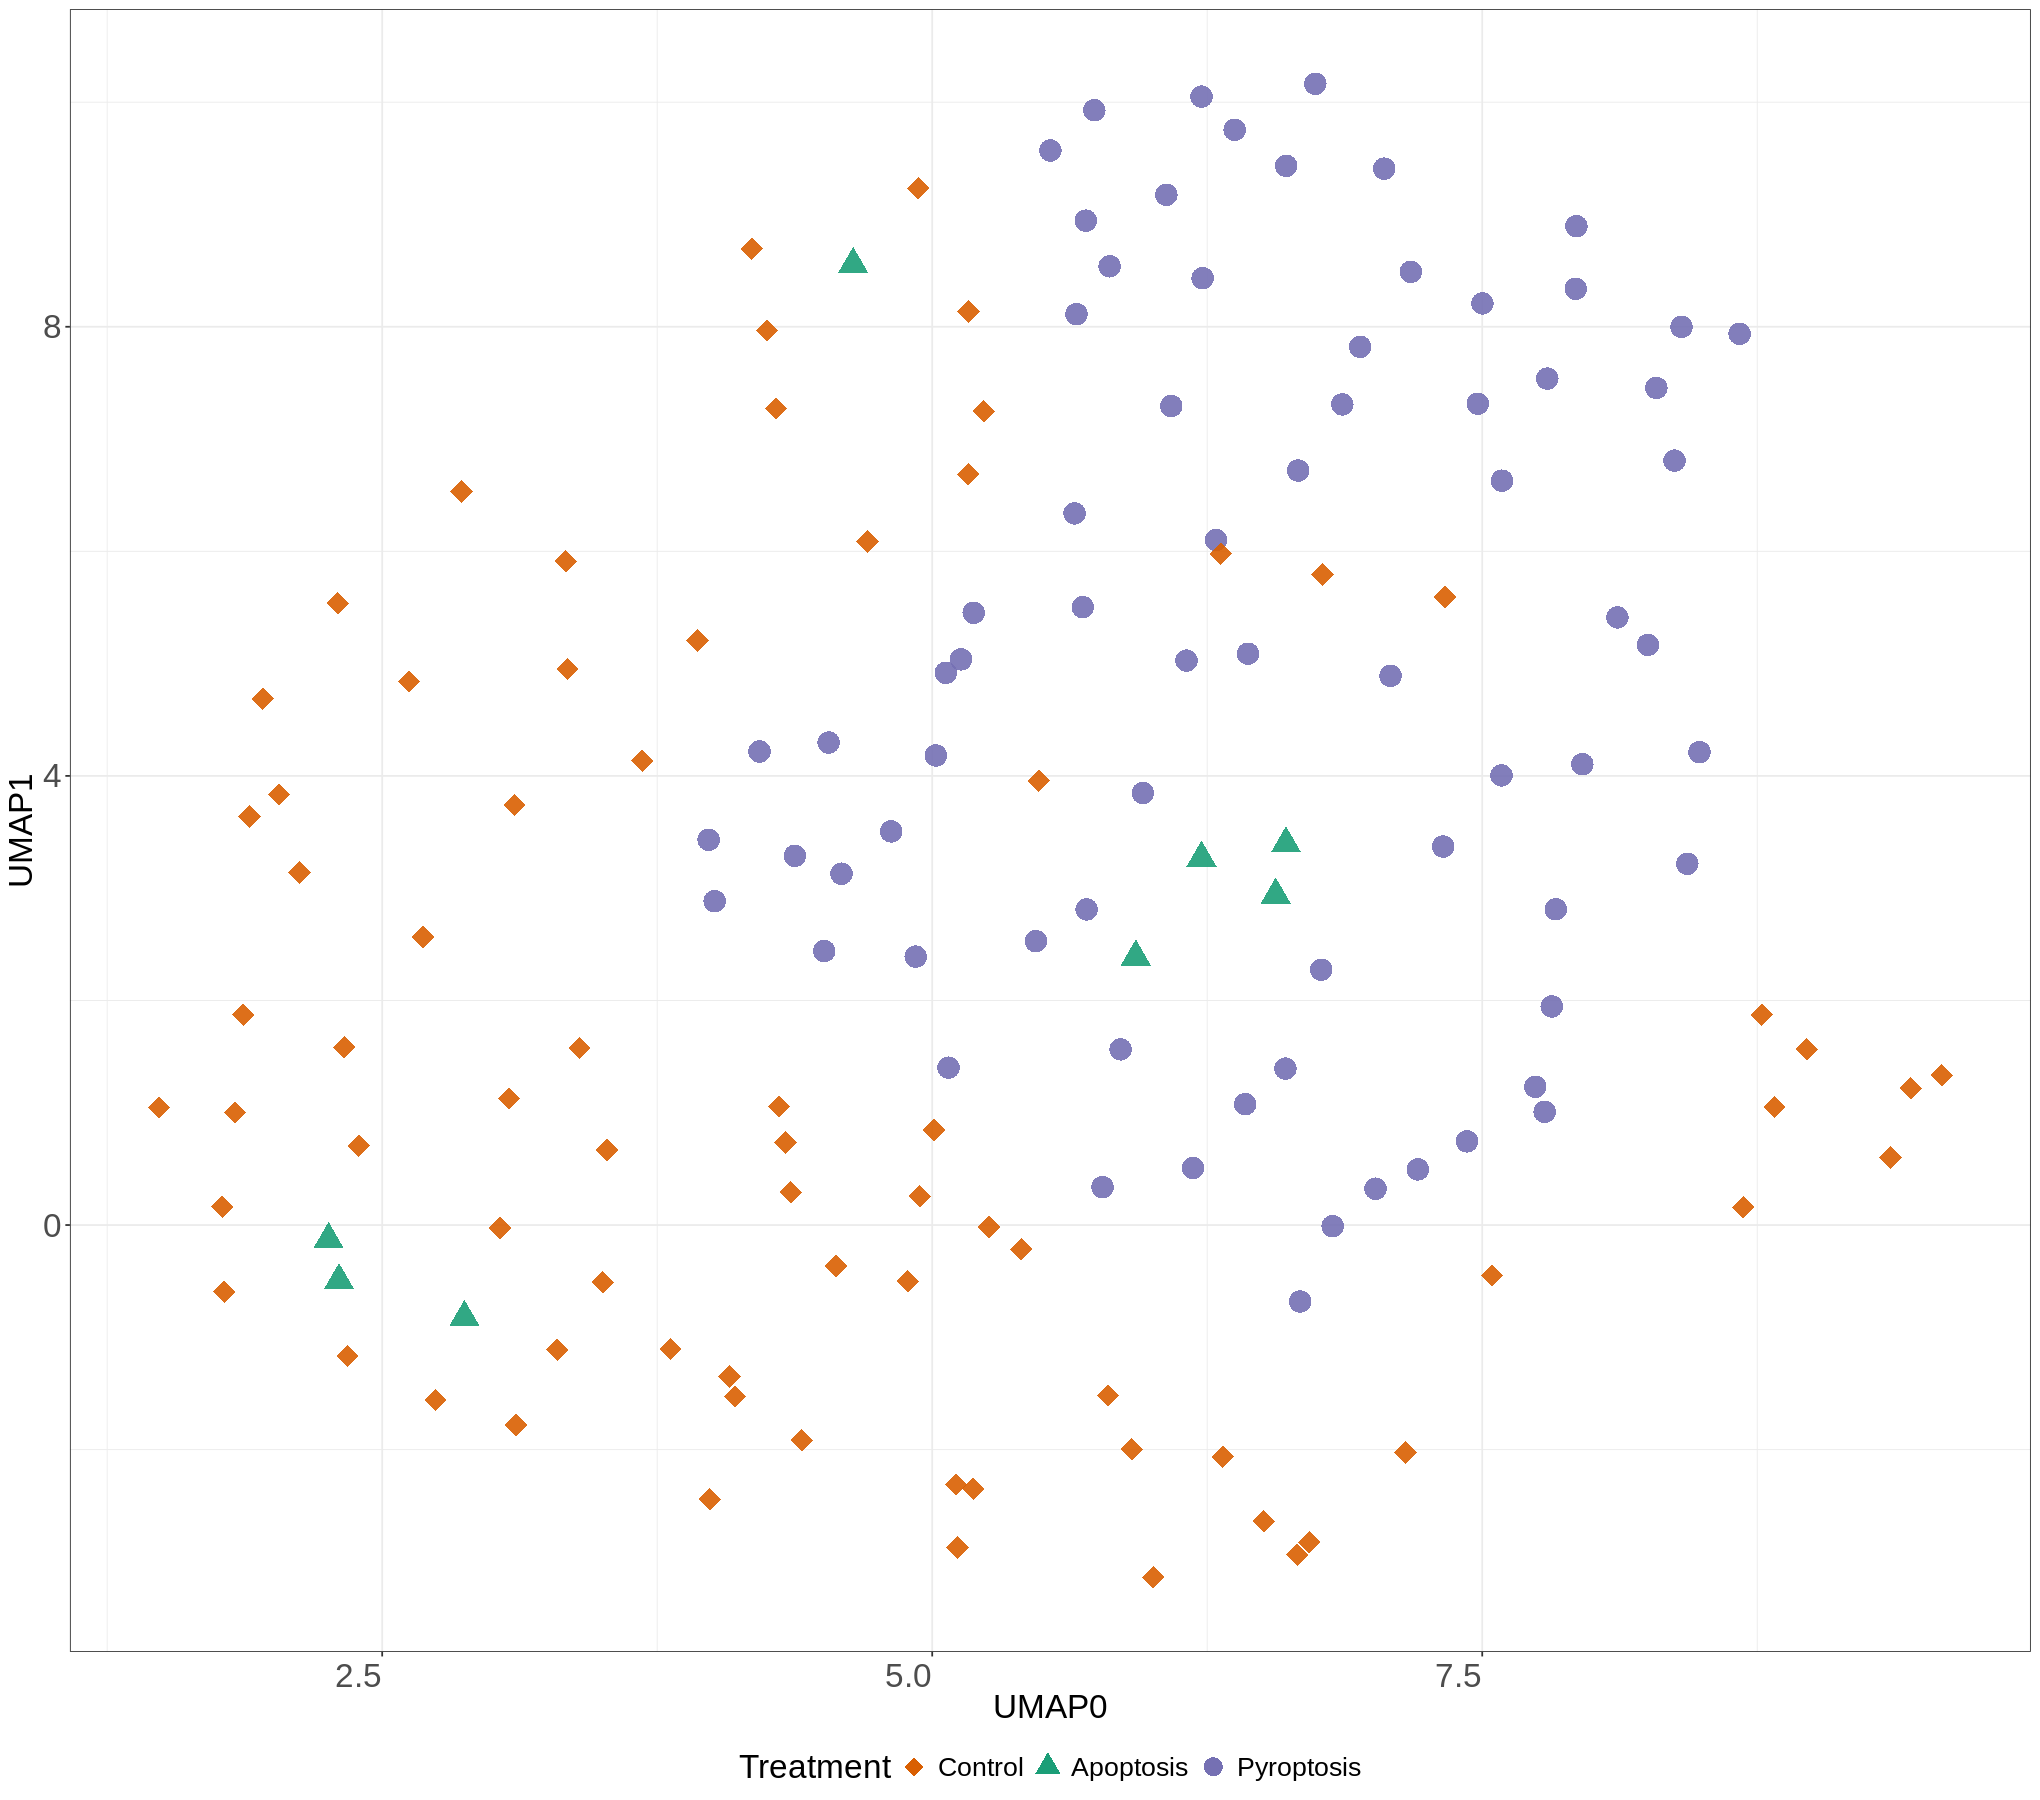

In [19]:
# set plot size 
width <- 17
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
umap_plot_all <- (
    ggplot(bulk_profile_umap_df, aes(x = UMAP1, y = UMAP2)) 

    + geom_point(
        aes(
            color = group,
            shape = group
        ), 
        size = 6, 
        alpha = 0.9
    )
    + theme_bw()
    + figure_theme

    # rename legend title
    + figure_theme
        + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))
            + theme(
        legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
    + scale_color_manual(
        name = "Treatment",
        labels = c(
        'Control',
        'Apoptosis',
        'Pyroptosis'
        ),
        values = c(
            brewer.pal(3, "Dark2")[2],
            brewer.pal(3, "Dark2")[1],
            brewer.pal(3, "Dark2")[3]
        ))
    + scale_shape_manual(
        name = "Treatment",
        labels = c(
        'Control',
        'Apoptosis',
        'Pyroptosis'
        ),
        values = c(
        18,
        17,
        16
        ))
    + theme(legend.position = "bottom")
    # set the legend columns to 4
    # change legend alpha 
    + guides(color = guide_legend(ncol = 3, override.aes = list(alpha = 1, size = 5)))
    + guides(shape = guide_legend(ncol = 1, override.aes = list(alpha = 1, size = 5)))
    + labs(
        x = "UMAP0",
        y = "UMAP1"
    )   
)
umap_plot_all
# save plot
ggsave(
    filename = file.path("..","figures", "all_treatments_cell_death_class_bulk_umap.png"),
    plot = umap_plot_all,
    width = width,
    height = height,
    units = "in",
    dpi = 600
)
